# NAWI Alliance Spring Meeting 2023: 
# Interactive Code Demonstration Using WaterTAP

### Today's demonstration will show 
- Part 1: how to build, initialize, simulate, and optimize a flowsheet using the coded interface. This will be demonstrated with a nanofiltration (NF) unit model based on the Donnan Steric Pore Model with Dielectric Exclusion (DSPM-DE).
- Part 2: demonstrate simulation and optimization of an NF DSPM-DE flowsheet in WaterTAP's graphical user interface.
- Useful Links:
    - Public Github Repository: https://github.com/watertap-org/watertap
    - Documentation: https://watertap.readthedocs.io/en/stable/
    - Installer for User Interface: https://watertap-org.github.io/

# Part 1: Build, setup, simulate, and optimize the NF DSPM-DE unit model

<img src="nf_ui.png" width="500" height="340">

<img src="nf_dspmde_transport_mechanisms.png" width="500" height="340">
Image source: <a href="https://doi.org/10.1016/j.desal.2017.07.020">Roy et al., 2017</a>


## Step 1: Import libraries from Pyomo, IDAES, and WaterTAP.

### Import some essentials from Pyomo and IDAES:

In [1]:
# Imports from Pyomo
from pyomo.environ import (ConcreteModel, 
                           Constraint, 
                           Objective, 
                           Var,
                           value, 
                           units as pyunits, 
                           assert_optimal_termination,
                           check_optimal_termination,
                           TransformationFactory,
                           NonNegativeReals)
from pyomo.network import Arc

# Imports from IDAES:
# Import flowsheet block from IDAES core
from idaes.core import FlowsheetBlock

# Import propagate_state to initialize state variables between units
from idaes.core.util.initialization import propagate_state

# Import function to get default solver
from idaes.core.solvers import get_solver

# Import function to check degrees of freedom
from idaes.core.util.model_statistics import degrees_of_freedom

# Import utility function for calculating scaling factors
from idaes.core.util.scaling import calculate_scaling_factors, set_scaling_factor, constraint_scaling_transform

# Import IDAES units
from idaes.models.unit_models import Feed, Product

import idaes.logger as idaeslog
_log = idaeslog.getLogger(__name__)


### WaterTAP Imports: 
* multicomponent property model
* pump
* NF DSPM-DE unit model
* configuration options, which can be used to change underlying model assumptions

In [2]:
# Imports from WaterTAP
# Import MultiComponent Aqueous Solution property model
from watertap.property_models.multicomp_aq_sol_prop_pack import (MCASParameterBlock, 
                                                                 ActivityCoefficientModel,
                                                                 DensityCalculation,)
# Import pump model
from watertap.unit_models.pressure_changer import Pump

# Import NF DSPM-DE model
from watertap.unit_models.nanofiltration_DSPMDE_0D import (
    NanofiltrationDSPMDE0D,
    MassTransferCoefficient,
    ConcentrationPolarizationType,
)

### Imports for costing:

In [3]:
from idaes.core import UnitModelCostingBlock
from watertap.costing import WaterTAPCosting

## Step 2: Start building the components needed in the NF DSPM-DE flowsheet.

### Create a Pyomo concrete model and flowsheet 

In [4]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

### Set up solute/solution properties required by the DSPM-DE model.
* Define a list of solutes
* For each solute, provide data on
    * Diffusivity
    * Molecular weight
    * Stokes' radius
    * Charge
* Choose ideal solution (activity coefficients=1) or Davies model

In [5]:
property_kwds = {
"solute_list": [
    "Ca_2+",
    "SO4_2-",
    "HCO3_-",
    "Na_+",
    "Cl_-",
],
    
"diffusivity_data": {
    ("Liq", "Ca_2+"): 9.2e-10,
    ("Liq", "SO4_2-"): 1.06e-9,
    ("Liq", "HCO3_-"): 1.19e-9,
    ("Liq", "Na_+"): 1.33e-9,
    ("Liq", "Cl_-"): 2.03e-9,
},
    
"mw_data": {
    "H2O": 18e-3,
    "Ca_2+": 40e-3,
    "HCO3_-": 61.0168e-3,
    "SO4_2-": 96e-3,
    "Na_+": 23e-3,
    "Cl_-": 35e-3,
},
    
"stokes_radius_data": {
    "Ca_2+": 0.309e-9,
    "HCO3_-": 2.06e-10,
    "SO4_2-": 0.230e-9,
    "Cl_-": 0.121e-9,
    "Na_+": 0.184e-9,
},
    
"charge": {
    "Ca_2+": 2,
    "HCO3_-": -1,
    "SO4_2-": -2,
    "Na_+": 1,
    "Cl_-": -1,
},
    
"activity_coefficient_model": ActivityCoefficientModel.davies,
}

### Create an instance of WaterTAP's multicomponent aqueous solution (MCAS) property model

In [6]:
m.fs.properties = MCASParameterBlock(**property_kwds)

### Add a feed, product, and disposal blocks
* Feed for inlet composition
* Product for NF permeate
* Disposal for NF concentrate

In [7]:
m.fs.feed = Feed(property_package=m.fs.properties)
m.fs.product = Product(property_package=m.fs.properties)
m.fs.disposal = Product(property_package=m.fs.properties)

### Add a pump and an NF DSPM-DE unit to the flowsheet.

In [8]:
m.fs.pump = Pump(property_package=m.fs.properties)
m.fs.unit = NanofiltrationDSPMDE0D(property_package=m.fs.properties,
                                  concentration_polarization_type=ConcentrationPolarizationType.calculated,
                                  mass_transfer_coefficient=MassTransferCoefficient.spiral_wound,
                                  has_pressure_change=True)

### Now, let's connect all of our units within the flowsheet. 

In [9]:
m.fs.feed_to_pump = Arc(source=m.fs.feed.outlet, destination=m.fs.pump.inlet)

m.fs.pump_to_nf = Arc(source=m.fs.pump.outlet, destination=m.fs.unit.inlet)

m.fs.nf_to_product = Arc(source=m.fs.unit.permeate, destination=m.fs.product.inlet)

m.fs.nf_to_disposal = Arc(source=m.fs.unit.retentate, destination=m.fs.disposal.inlet)

TransformationFactory("network.expand_arcs").apply_to(m)

## Step 3: Specify values for system variables.

### Fix inlet state variables 
* mole flow rates of each component
* temperature
* pressure

#### From mass fractions of each ion in solution, calculate molar flow rates--the state variables of our property model

In [10]:
m.fs.feed.properties[0].temperature.fix(298.15)
m.fs.feed.properties[0].pressure.fix(101325)

feed_mass_frac = {
    "Ca_2+": 4.0034374454637006e-04,
    "HCO3_-": 0.00022696833343821863,
    "SO4_2-": 0.00020497140244420624,
    "Cl_-": 0.0004559124032433401,
    "Na_+": 0.00043333830389924205,
}
H2O_mass_frac = 1 - sum(x for x in feed_mass_frac.values())

# scale molar flowrate variables
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1/0.01, index=("Liq", "Ca_2+"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1/0.002, index=("Liq", "SO4_2-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1/0.0037, index=("Liq", "HCO3_-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1/0.013, index=("Liq", "Cl_-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1/0.018, index=("Liq", "Na_+"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1/55, index=("Liq", "H2O"))

m.fs.feed.properties[0].mass_frac_phase_comp
m.fs.feed.properties[0].conc_mol_phase_comp
m.fs.feed.properties[0].conc_mass_phase_comp
m.fs.feed.properties[0].flow_vol_phase
calculate_scaling_factors(m.fs.feed.properties[0])
m.fs.feed.properties.calculate_state(
    var_args={
        ("mass_frac_phase_comp", ("Liq", "Ca_2+")): 4.0034374454637006e-04,
        ("mass_frac_phase_comp", ("Liq", "HCO3_-")): 0.00022696833343821863,
        ("mass_frac_phase_comp", ("Liq", "SO4_2-")): 0.00020497140244420624,
        ("mass_frac_phase_comp", ("Liq", "Cl_-")): 0.0004559124032433401,
        ("mass_frac_phase_comp", ("Liq", "Na_+")): 0.00043333830389924205,
        ("flow_vol_phase", "Liq"): 1e-3,  

    },  
    hold_state=True);
m.fs.feed.display()

Block fs.feed

  Variables:
    flow_mol_phase_comp : Size=6, Index=fs.feed.flow_mol_phase_comp_index, ReferenceTo=fs.feed.properties[:].component('flow_mol_phase_comp')[...]
        Key                    : Lower : Value                 : Upper : Fixed : Stale : Domain
         (0.0, 'Liq', 'Ca_2+') :     0 :  0.010008593613659252 :  None :  True : False : NonNegativeReals
          (0.0, 'Liq', 'Cl_-') :     0 :   0.01302606866409543 :  None :  True : False : NonNegativeReals
           (0.0, 'Liq', 'H2O') :     0 :     55.45991476735714 :  None :  True : False : NonNegativeReals
        (0.0, 'Liq', 'HCO3_-') :     0 : 0.0037197678907812046 :  None :  True : False : NonNegativeReals
          (0.0, 'Liq', 'Na_+') :     0 :  0.018840795821706172 :  None :  True : False : NonNegativeReals
        (0.0, 'Liq', 'SO4_2-') :     0 : 0.0021351187754604815 :  None :  True : False : NonNegativeReals
    temperature : Size=1, Index=fs._time, ReferenceTo=fs.feed.properties[:].component('temper

### Display feed composition

In [11]:
print("Mole flow rates (mole/s)")
[print(f"{j} = {value(m.fs.feed.properties[0].flow_mol_phase_comp['Liq', j])}") for j in m.fs.properties.component_list];
print("\nMolarities (mol/m3)")
[print(f"{j} = {value(m.fs.feed.properties[0].conc_mol_phase_comp['Liq', j])}") for j in m.fs.properties.component_list];
print("\nMass fractions (ppm)")
[print(f"{j} = {value(m.fs.feed.properties[0].mass_frac_phase_comp['Liq', j])*1e6}") for j in m.fs.properties.component_list];

Mole flow rates (mole/s)
H2O = 55.45991476735714
Ca_2+ = 0.010008593613659252
SO4_2- = 0.0021351187754604815
HCO3_- = 0.0037197678907812046
Na_+ = 0.018840795821706172
Cl_- = 0.01302606866409543

Molarities (mol/m3)
H2O = 55459.91476735716
Ca_2+ = 10.008593613659253
SO4_2- = 2.135118775460482
HCO3_- = 3.7197678907812057
Na_+ = 18.84079582170618
Cl_- = 13.026068664095433

Mass fractions (ppm)
H2O = 998278.4658124286
Ca_2+ = 400.3437445463701
SO4_2- = 204.97140244420623
HCO3_- = 226.96833343821862
Na_+ = 433.3383038992421
Cl_- = 455.91240324334007


### Use assert_electroneutrality method from property model to ensure the ion concentrations provided obey electroneutrality condition

In [12]:
m.fs.feed.properties[0].assert_electroneutrality(
    defined_state=True,
    adjust_by_ion="Cl_-",
)

Cl_- adjusted: fs.feed.properties[0.0].flow_mol_phase_comp['Liq',Cl_-] was adjusted from 0.01302606866409543 and fixed to 0.03086797760732251. Electroneutrality satisfied for fs.feed.properties[0.0]. Balance Result = -3.552713678800501e-15


### Display feed composition again, after adjustment to achieve electroneutrality

In [13]:
print("Mole flow rates (mole/s)")
[print(f"{j} = {value(m.fs.feed.properties[0].flow_mol_phase_comp['Liq', j])}") for j in m.fs.properties.component_list];
print("\nMolarities (mol/m3)")
[print(f"{j} = {value(m.fs.feed.properties[0].conc_mol_phase_comp['Liq', j])}") for j in m.fs.properties.component_list];
print("\nMass fractions (ppm)")
[print(f"{j} = {value(m.fs.feed.properties[0].mass_frac_phase_comp['Liq', j])*1e6}") for j in m.fs.properties.component_list];

Mole flow rates (mole/s)
H2O = 55.45991476735714
Ca_2+ = 0.010008593613659252
SO4_2- = 0.0021351187754604815
HCO3_- = 0.0037197678907812046
Na_+ = 0.018840795821706172
Cl_- = 0.03086797760732251

Molarities (mol/m3)
H2O = 55425.30350471728
Ca_2+ = 10.002347479606017
SO4_2- = 2.133786296732111
HCO3_- = 3.717446468832268
Na_+ = 18.829037712533722
Cl_- = 30.84871360944927

Mass fractions (ppm)
H2O = 997655.463084911
Ca_2+ = 400.09389918424057
SO4_2- = 204.84348448628265
HCO3_- = 226.8266876994447
Na_+ = 433.06786738827583
Cl_- = 1079.7049763307245


### Fix pump variables for initial simulation.
* Pump efficiency
* Pump discharge pressure

In [14]:
m.fs.pump.efficiency_pump[0].fix(0.75)
m.fs.pump.outlet.pressure[0].fix(3e5)

# To check units of pressure:
# print(str(m.fs.pump.outlet.pressure[0]._units))

### Fix the membrane variables that are typically fixed for the DSPM-DE model.
* membrane pore radius
* effective membrane thickness
* membrane charge density
* pore dielectric constant


In [15]:
m.fs.unit.radius_pore.fix(0.5e-9)
m.fs.unit.membrane_thickness_effective.fix(8.6e-07)
m.fs.unit.membrane_charge_density.fix(-680)
m.fs.unit.dielectric_constant_pore.fix(41.3)

# Fix final permeate pressure to be ~atmospheric
m.fs.unit.mixed_permeate[0].pressure.fix(101325)
m.fs.unit.deltaP.fix(0
                     *pyunits.bar)

m.fs.unit.spacer_porosity.fix(0.85)
m.fs.unit.channel_height.fix(1e-3)
m.fs.unit.velocity[0, 0].fix(0.25)
m.fs.unit.area.fix(50)

# Fix additional variables for calculating mass transfer coefficient with spiral wound correlation
m.fs.unit.spacer_mixing_efficiency.fix()
m.fs.unit.spacer_mixing_length.fix()

# Create on-demand property, "total hardness" for the NF permeate by "touching" it
m.fs.product.properties[0].total_hardness;

## Step 4: Calculate scaling factors for variables.
We can aim for scaling factors that are approximately the inverse of variable values. 
For example, if we know pressure is typically around 1e6 Pa, we could apply a scaling factor of 1e-6 to scale the variable value of pressure to 1.


In [16]:
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1/0.01, index=("Liq", "Ca_2+"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1/0.002, index=("Liq", "SO4_2-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1/0.0037, index=("Liq", "HCO3_-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1/0.013, index=("Liq", "Cl_-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1/0.018, index=("Liq", "Na_+"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1/55, index=("Liq", "H2O"))

set_scaling_factor(m.fs.unit.area, 0.1)

calculate_scaling_factors(m);

2023-10-10 15:55:58 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.work


## Step 5: Initialize the model.

In [17]:
m.fs.feed.initialize()

propagate_state(m.fs.feed_to_pump)
m.fs.pump.initialize()

propagate_state(m.fs.pump_to_nf)
m.fs.unit.initialize()

propagate_state(m.fs.nf_to_product)
propagate_state(m.fs.nf_to_disposal)
m.fs.product.initialize()

2023-10-10 15:56:05 [INFO] idaes.init.fs.feed: Initialization Complete.
2023-10-10 15:56:05 [INFO] idaes.init.fs.pump.control_volume: Initialization Complete
2023-10-10 15:56:06 [INFO] idaes.init.fs.pump: Initialization Complete: optimal - Optimal Solution Found
2023-10-10 15:56:07 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found
2023-10-10 15:56:07 [INFO] idaes.init.fs.product: Initialization Complete.


In [18]:
m.fs.feed.report()
m.fs.pump.report()
m.fs.unit.report()


Unit : fs.feed                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                              Units        Outlet  
    flow_mol_phase_comp ('Liq', 'H2O')     mole / second     55.460
    flow_mol_phase_comp ('Liq', 'Ca_2+')   mole / second   0.010009
    flow_mol_phase_comp ('Liq', 'SO4_2-')  mole / second  0.0021351
    flow_mol_phase_comp ('Liq', 'HCO3_-')  mole / second  0.0037198
    flow_mol_phase_comp ('Liq', 'Na_+')    mole / second   0.018841
    flow_mol_phase_comp ('Liq', 'Cl_-')    mole / second   0.030868
    temperature                                   kelvin     298.15
    pressure                                      pascal 1.0132e+05

Unit : fs.pump                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Var

### Display feed pressure, membrane area, and rejection rates after initializing the flowsheet.

In [19]:
m.fs.unit.inlet.pressure[0].display()
m.fs.unit.area.display()
m.fs.unit.rejection_observed_phase_comp.display()
m.fs.unit.rejection_intrinsic_phase_comp.display()

pressure : State pressure
    Size=1, Index=None, Units=Pa
    Key  : Lower    : Value    : Upper : Fixed : Stale : Domain
    None : 100000.0 : 300000.0 :  None : False :  True : NonNegativeReals
area : Membrane area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value : Upper  : Fixed : Stale : Domain
    None :     0 :    50 : 1000.0 :  True :  True : NonNegativeReals
rejection_observed_phase_comp : Size=5
    Key                    : Value
     (0.0, 'Liq', 'Ca_2+') : 0.8463798230765682
      (0.0, 'Liq', 'Cl_-') : 0.6833627785935723
    (0.0, 'Liq', 'HCO3_-') : 0.7783867806030416
      (0.0, 'Liq', 'Na_+') : 0.6006871957634055
    (0.0, 'Liq', 'SO4_2-') : 0.9999731960568767
rejection_intrinsic_phase_comp : Intrinsic solute rejection
    Size=5, Index=fs.unit.rejection_intrinsic_phase_comp_index, Units=dimensionless
    Key                    : Lower  : Value              : Upper : Fixed : Stale : Domain
     (0.0, 'Liq', 'Ca_2+') : -1.001 :  0.883000122641012 : 1.001 : Fals

## Step 6: Setup a solver and run a simulation.

### The degrees of freedom should be 0 for a simulation.
Check that degrees of freedom = 0 before attempting simulation. This means that the performance of the flowsheet is completely determined by the system variables that were fixed above.

In [20]:
print(f"Degrees of freedom = {degrees_of_freedom(m)}")
assert degrees_of_freedom(m) == 0

Degrees of freedom = 0


### Setup solver

In [21]:
solver = get_solver()

### Run simulation


In [22]:
simulation_results = solver.solve(m)
assert_optimal_termination(simulation_results)

### Display feed pressure, membrane area, rejection rates, and water flux after simulation.

In [23]:
m.fs.pump.outlet.pressure[0].display()
m.fs.unit.area.display()
m.fs.unit.rejection_observed_phase_comp.display()
m.fs.unit.rejection_intrinsic_phase_comp.display()
print(f"\nAverage volumetric water flux={value(pyunits.convert(m.fs.unit.flux_vol_water_avg[0],to_units=pyunits.L/pyunits.m**2/pyunits.hour))} LMH")

pressure : State pressure
    Size=1, Index=None, Units=Pa
    Key  : Lower    : Value    : Upper : Fixed : Stale : Domain
    None : 100000.0 : 300000.0 :  None :  True :  True : NonNegativeReals
area : Membrane area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value : Upper  : Fixed : Stale : Domain
    None :     0 :    50 : 1000.0 :  True :  True : NonNegativeReals
rejection_observed_phase_comp : Size=5
    Key                    : Value
     (0.0, 'Liq', 'Ca_2+') : 0.8463798230812926
      (0.0, 'Liq', 'Cl_-') : 0.6833627785933696
    (0.0, 'Liq', 'HCO3_-') : 0.7783867806041104
      (0.0, 'Liq', 'Na_+') : 0.6006871957667971
    (0.0, 'Liq', 'SO4_2-') : 0.9999731960766272
rejection_intrinsic_phase_comp : Intrinsic solute rejection
    Size=5, Index=fs.unit.rejection_intrinsic_phase_comp_index, Units=dimensionless
    Key                    : Lower  : Value              : Upper : Fixed : Stale : Domain
     (0.0, 'Liq', 'Ca_2+') : -1.001 : 0.8830001226444372 : 1.001 : Fals

### Sweep across pressure and plot rejection rates 

In [24]:
import numpy as np
area = []
pressure = []
ca_rej = []
hco3_rej = []
na_rej = []
cl_rej = []
so4_rej = []
recovery = []
water_flux = []


m.fs.unit.area.setub(None)
# for r in np.arange(0.05,1,.10):
for p in np.arange(2e5,11e5,1e5):
    m.fs.pump.outlet.pressure.fix(p)    
    assert degrees_of_freedom(m)==0
    optimization_results = solver.solve(m, tee=False)
    try:
        assert_optimal_termination(optimization_results)
    except RuntimeError:
        optimization_results = solver.solve(m, tee=False)
        if not check_optimal_termination(optimization_results):
            continue
        else:
            pass
    area.append(value(m.fs.unit.area))
    pressure.append(value(m.fs.unit.inlet.pressure[0]))
    ca_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "Ca_2+"]))
    hco3_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "HCO3_-"]))
    na_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "Na_+"]))
    cl_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "Cl_-"]))
    so4_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "SO4_2-"]))
    recovery.append(value(m.fs.unit.recovery_vol_phase[0, "Liq"]))
    water_flux.append(value(m.fs.unit.flux_vol_water_avg[0]*3.6e6))

Text(0, 0.5, 'Intrinsic Rejection (-)')

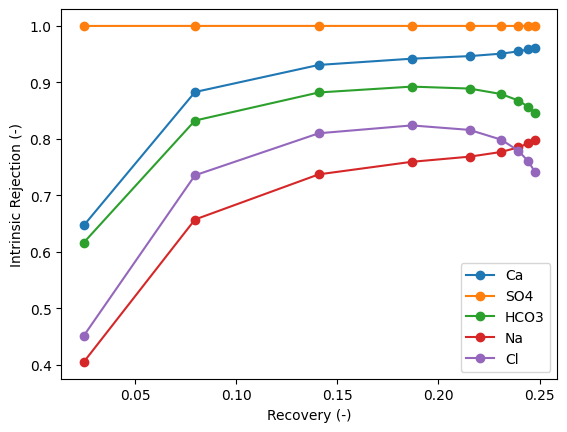

In [25]:
import matplotlib.pyplot as plt
plt.plot(recovery,ca_rej,'-o')
plt.plot(recovery,so4_rej,'-o')
plt.plot(recovery,hco3_rej,'-o')
plt.plot(recovery,na_rej,'-o')
plt.plot(recovery,cl_rej,'-o')
plt.legend(['Ca', 'SO4', 'HCO3', 'Na', 'Cl'])
plt.xlabel("Recovery (-)")
plt.ylabel("Intrinsic Rejection (-)")

Text(0, 0.5, 'Intrinsic Rejection (-)')

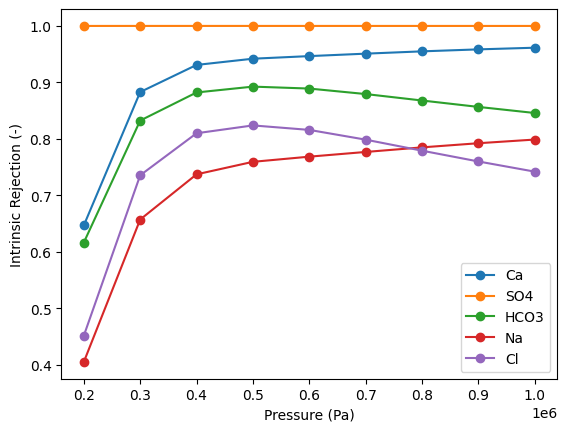

In [26]:
plt.plot(pressure,ca_rej,'-o')
plt.plot(pressure,so4_rej,'-o')
plt.plot(pressure,hco3_rej,'-o')
plt.plot(pressure,na_rej,'-o')
plt.plot(pressure,cl_rej,'-o')
plt.legend(['Ca', 'SO4', 'HCO3', 'Na', 'Cl'])
plt.xlabel("Pressure (Pa)")
plt.ylabel("Intrinsic Rejection (-)")

Text(0, 0.5, 'Intrinsic Rejection (-)')

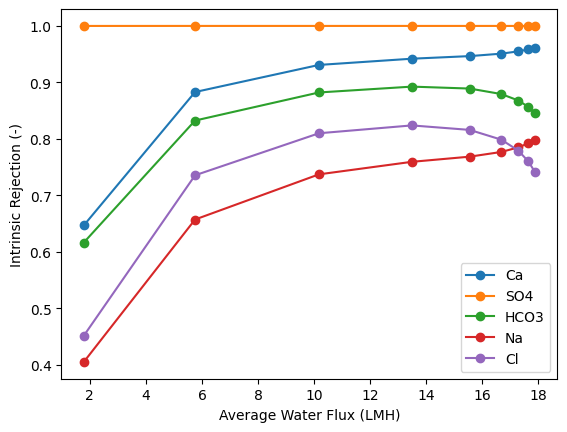

In [27]:
plt.plot(water_flux,ca_rej,'-o')
plt.plot(water_flux,so4_rej,'-o')
plt.plot(water_flux,hco3_rej,'-o')
plt.plot(water_flux,na_rej,'-o')
plt.plot(water_flux,cl_rej,'-o')
plt.legend(['Ca', 'SO4', 'HCO3', 'Na', 'Cl'])
plt.xlabel("Average Water Flux (LMH)")
plt.ylabel("Intrinsic Rejection (-)")

## Add costing to the flowsheet.

In [28]:
m.fs.costing = WaterTAPCosting()
m.fs.pump.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
m.fs.unit.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)

m.fs.costing.disposal_cost = Var(
        initialize=0.1,
        bounds=(0, None),
        doc="disposal cost",
        units=pyunits.USD_2018 / pyunits.m**3,
    )
m.fs.costing.disposal_cost.fix()
m.fs.costing.register_flow_type("disposal", m.fs.costing.disposal_cost)
m.fs.costing.cost_flow(m.fs.disposal.properties[0].flow_vol_phase["Liq"], "disposal")
m.fs.costing.base_currency = pyunits.USD_2018
m.fs.costing.cost_process()
    
m.fs.costing.add_annual_water_production(m.fs.product.properties[0].flow_vol)
m.fs.costing.add_LCOW(m.fs.product.properties[0].flow_vol)
m.fs.costing.add_specific_energy_consumption(m.fs.product.properties[0].flow_vol)

### Initialize the costing block

In [29]:
m.fs.costing.initialize()

### Run simulation with costing included

In [30]:
simulation_with_cost_results=solver.solve(m)
assert_optimal_termination(simulation_with_cost_results)

### Check SEC and LCOW results without any optimization.

In [31]:
m.fs.pump.outlet.pressure.display()
m.fs.unit.area.display()
m.fs.unit.rejection_observed_phase_comp.display()
m.fs.unit.rejection_intrinsic_phase_comp.display()
print(f"\nAverage volumetric water flux={value(pyunits.convert(m.fs.unit.flux_vol_water_avg[0],to_units=pyunits.L/pyunits.m**2/pyunits.hour))} LMH")
m.fs.costing.specific_energy_consumption.display()
m.fs.costing.LCOW.display()

_pressure_outlet_ref : Size=1, Index=fs._time, ReferenceTo=fs.pump.control_volume.properties_out[...].component('pressure')
    Key : Lower    : Value     : Upper : Fixed : Stale : Domain
    0.0 : 100000.0 : 1000000.0 :  None :  True :  True : NonNegativeReals
area : Membrane area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :     0 :    50 :  None :  True :  True : NonNegativeReals
rejection_observed_phase_comp : Size=5
    Key                    : Value
     (0.0, 'Liq', 'Ca_2+') :  0.5735099712137084
      (0.0, 'Liq', 'Cl_-') :  0.4866930342299327
    (0.0, 'Liq', 'HCO3_-') :  0.3595532350006797
      (0.0, 'Liq', 'Na_+') : 0.48523094420881474
    (0.0, 'Liq', 'SO4_2-') :  0.9979560399351302
rejection_intrinsic_phase_comp : Intrinsic solute rejection
    Size=5, Index=fs.unit.rejection_intrinsic_phase_comp_index, Units=dimensionless
    Key                    : Lower  : Value              : Upper : Fixed : Stale : Domain
   

## Step 7: Unfix variables, set variable bounds, and run optimization.

### Unfix membrane area, feed pressure, and inlet velocity.


In [32]:
m.fs.unit.area.unfix()                   # membrane area (m^2)
m.fs.pump.outlet.pressure[0].unfix()     # feed pressure (Pa)

### Set lower and upper bounds for membrane area; set upper bound for NF inlet pressure.



In [33]:
m.fs.unit.area.setlb(1)
m.fs.unit.area.setub(None)
m.fs.unit.inlet.pressure[0].setub(40e5)

### Define objective function to minimize the specific energy consumption.


In [34]:
m.fs.sec_objective = Objective(expr=m.fs.costing.specific_energy_consumption)

### Add a constraint limiting the maximum hardness of the permeate.

In [35]:
m.fs.max_hardness = Var(
        initialize=250,
        domain=NonNegativeReals,
        units=pyunits.mg / pyunits.L,
        doc="Maximum total hardness as CaCO3",
    )
m.fs.max_hardness.fix(0.5*value(m.fs.feed.properties[0].total_hardness))

m.fs.max_hardness_constraint = Constraint(expr=m.fs.unit.mixed_permeate[0].total_hardness 
                               <= m.fs.max_hardness)
# Scale the new constraint
set_scaling_factor(m.fs.unit.mixed_permeate[0].total_hardness , 1/value(m.fs.unit.mixed_permeate[0].total_hardness) )
set_scaling_factor(m.fs.max_hardness , 1/value(m.fs.max_hardness) )
constraint_scaling_transform(m.fs.max_hardness_constraint,  1/value(m.fs.max_hardness))

### The solver will optimize membrane area, inlet pressure, and recovery rate, while minimizing specific energy consumption. Let's check the degrees of freedom.

In [36]:
print(degrees_of_freedom(m))

2


### Solve the model, optimizing with 2 degrees of freedom

In [37]:
optimization_results = solver.solve(m,tee=True)
assert_optimal_termination(optimization_results)

ipopt-watertap: Ipopt with user variable scaling and IDAES jacobian constraint scaling
Ipopt 3.13.2: tol=1e-08
constr_viol_tol=1e-08
nlp_scaling_method=user-scaling
bound_relax_factor=0.0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the

### Check SEC-optimal results for
* membrane area
* pump pressure
* recovery rate
* SEC
* LCOW
* rejection rates

In [38]:
m.fs.unit.area.display()

m.fs.pump.outlet.pressure.display()

m.fs.unit.recovery_vol_phase.display()

m.fs.costing.specific_energy_consumption.display()

m.fs.costing.LCOW.display()

m.fs.unit.rejection_observed_phase_comp.display()

m.fs.unit.rejection_intrinsic_phase_comp.display()

print(f"\nAverage volumetric water flux={value(pyunits.convert(m.fs.unit.flux_vol_water_avg[0],to_units=pyunits.L/pyunits.m**2/pyunits.hour))} LMH")

## Previous SEC and LCOW results from simulation:
# specific_energy_consumption : Size=1
#     Key  : Value
#     None : 1.3444516491470768
# LCOW : Levelized Cost of Water based on flow fs.product.properties[0.0].flow_vol
#     Size=1, Index=None, Units=USD_2018/m**3
#     Key  : Lower : Value              : Upper : Fixed : Stale : Domain
#     None :  None : 0.5316151578977553 :  None : False : False :  Reals

area : Membrane area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :     1 : 1091.328553600216 :  None : False : False : NonNegativeReals
_pressure_outlet_ref : Size=1, Index=fs._time, ReferenceTo=fs.pump.control_volume.properties_out[...].component('pressure')
    Key : Lower    : Value              : Upper : Fixed : Stale : Domain
    0.0 : 100000.0 : 224532.54120012448 :  None : False : False : NonNegativeReals
recovery_vol_phase : Volumetric-based recovery
    Size=1, Index=fs.unit.recovery_vol_phase_index, Units=dimensionless
    Key          : Lower : Value             : Upper : Fixed : Stale : Domain
    (0.0, 'Liq') :     0 : 0.623123588389094 :     1 : False : False :  Reals
specific_energy_consumption : Size=1
    Key  : Value
    None : 0.07323173687692071
LCOW : Levelized Cost of Water based on flow fs.product.properties[0.0].flow_vol
    Size=1, Index=None, Units=USD_2018/m**3
    Key  : Lower : Value     

### Add an objective function to minimize the LCOW and optimize again.

#### Deactivate the SEC objective first.

In [39]:
m.fs.sec_objective.deactivate()
m.fs.lcow_objective = Objective(expr=m.fs.costing.LCOW)

In [40]:
# Fix recovery rate to match the recovery rate of the SEC minimization result
m.fs.unit.recovery_vol_phase.fix()

optimization_results = solver.solve(m, tee=True)
assert_optimal_termination(optimization_results)

ipopt-watertap: Ipopt with user variable scaling and IDAES jacobian constraint scaling
Ipopt 3.13.2: tol=1e-08
constr_viol_tol=1e-08
nlp_scaling_method=user-scaling
bound_relax_factor=0.0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the

RuntimeError: Solver failed to return an optimal solution. Solver status: warning, Termination condition: maxIterations

### Check results after cost optimization.

In [41]:
m.fs.unit.area.display()

m.fs.pump.outlet.pressure.display()

m.fs.unit.recovery_vol_phase.display()

m.fs.costing.specific_energy_consumption.display()

m.fs.costing.LCOW.display()

m.fs.unit.rejection_observed_phase_comp.display()

m.fs.unit.rejection_intrinsic_phase_comp.display()

print(f"\nAverage volumetric water flux={value(pyunits.convert(m.fs.unit.flux_vol_water_avg[0],to_units=pyunits.L/pyunits.m**2/pyunits.hour))} LMH")

## Previous results from SEC optimization:
# specific_energy_consumption : Size=1
#     Key  : Value
#     None : 0.1707081027046537
# LCOW : Levelized Cost of Water based on flow fs.product.properties[0.0].flow_vol
#     Size=1, Index=None, Units=USD_2018/m**3
#     Key  : Lower : Value              : Upper : Fixed : Stale : Domain
#     None :  None : 0.2921494718570934 :  None : False : False :  Reals

## Previous results from simulation:
# specific_energy_consumption : Size=1
#     Key  : Value
#     None : 1.3444516491470768
# LCOW : Levelized Cost of Water based on flow fs.product.properties[0.0].flow_vol
#     Size=1, Index=None, Units=USD_2018/m**3
#     Key  : Lower : Value              : Upper : Fixed : Stale : Domain
#     None :  None : 0.5316151578977553 :  None : False : False :  Reals

area : Membrane area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :     1 : 393.7629174573016 :  None : False : False : NonNegativeReals
_pressure_outlet_ref : Size=1, Index=fs._time, ReferenceTo=fs.pump.control_volume.properties_out[...].component('pressure')
    Key : Lower    : Value             : Upper : Fixed : Stale : Domain
    0.0 : 100000.0 : 339006.3636684886 :  None : False : False : NonNegativeReals
recovery_vol_phase : Volumetric-based recovery
    Size=1, Index=fs.unit.recovery_vol_phase_index, Units=dimensionless
    Key          : Lower : Value             : Upper : Fixed : Stale : Domain
    (0.0, 'Liq') :     0 : 0.623123588389094 :     1 :  True :  True :  Reals
specific_energy_consumption : Size=1
    Key  : Value
    None : 0.13584997788577535
LCOW : Levelized Cost of Water based on flow fs.product.properties[0.0].flow_vol
    Size=1, Index=None, Units=USD_2018/m**3
    Key  : Lower : Value       

#### Quick TDS calcs


In [42]:
feed_tds=[value(sum(m.fs.feed.properties[0].mass_frac_phase_comp['Liq', j] for j in m.fs.properties.solute_set))]
perm_tds= [value(sum(m.fs.product.properties[0].mass_frac_phase_comp['Liq', j] for j in m.fs.properties.solute_set))]
print(f"TDS rejection = {1-perm_tds[0]/feed_tds[0]}")

TDS rejection = -1065.3086469750588


#### Print total hardness in feed, permeate, and brine.

In [43]:
feed_TH=value(m.fs.feed.properties[0].total_hardness)
brine_TH=value(m.fs.disposal.properties[0].total_hardness)
perm_TH=value(m.fs.product.properties[0].total_hardness)

print("TH rejection",1-perm_TH/feed_TH)
print("Total hardness (mg/L as CaCO3):\n")
print("Feed:",feed_TH)
print("Brine:",brine_TH)
print("Permeate:",perm_TH)

TH rejection 0.6787436543673242
Total hardness (mg/L as CaCO3):

Feed: 1001.1039556355236
Brine: 1000
Permeate: 321.6109983858847


## Summary: 
### We covered how to build, scale, initialize, simulate and optimize a flowsheet, using the NF DSPM-DE as an example.

### Moving on to Part 2: demonstrate simulation and optimization of an NF DSPM-DE flowsheet in WaterTAP's graphical user interface (GUI). 

### The GUI installer can be downloaded from our homepage at: https://watertap-org.github.io/